In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 9)
plt.rcParams['font.size'] = 16
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import covid19

## data

In [3]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
# data_italy_path = covid19.data.download('andamento-nazionale')

In [4]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])
data_italy.index = data_italy.index.normalize()

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,,
2020-03-09,ITA,4316,733,5049,2936,7985,1598,724,463,9172,53826
2020-03-10,ITA,5038,877,5915,2599,8514,529,1004,631,10149,60761
2020-03-11,ITA,5838,1028,6866,3724,10590,2076,1045,827,12462,73154
2020-03-12,ITA,6650,1153,7803,5036,12839,2249,1258,1016,15113,86011
2020-03-13,ITA,7426,1328,8754,6201,14955,2116,1439,1266,17660,97488


## situation report

In [5]:
START_FIT = '2020-02-24'
STOP_FIT = None
EXTRAPOLTATE = ('2020-02-23', '2020-03-14')

In [6]:
fits = {}
fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame('dimessi_guariti', data_italy, start='2020-02-27', stop=STOP_FIT)
fits[''] = covid19.fit.ExponentialFit.from_frame('dimessi_guariti', data_italy, start='2020-02-27', stop=STOP_FIT)

fits['ricoverati_con_sintomi_old'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start=START_FIT, stop='2020-03-05')
fits['terapia_intensiva_old'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start=START_FIT, stop='2020-03-06')
fits['deceduti_old'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start=START_FIT, stop='2020-03-10')

fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-06', stop='2020-03-12')
fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-07', stop=STOP_FIT)
fits['deceduti'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start='2020-03-11', stop=STOP_FIT)


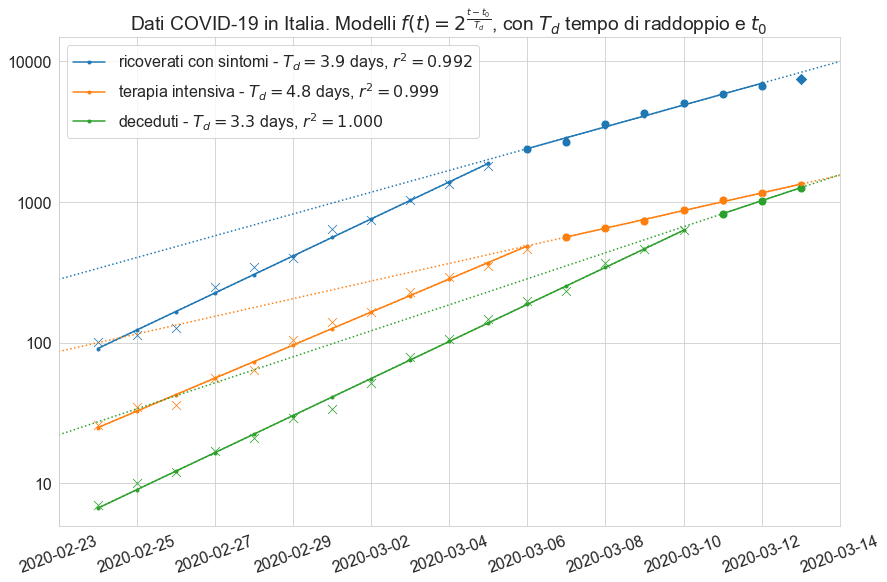

In [7]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 15000)})
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_old'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_old'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_old'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=2)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio e $t_0$ ')

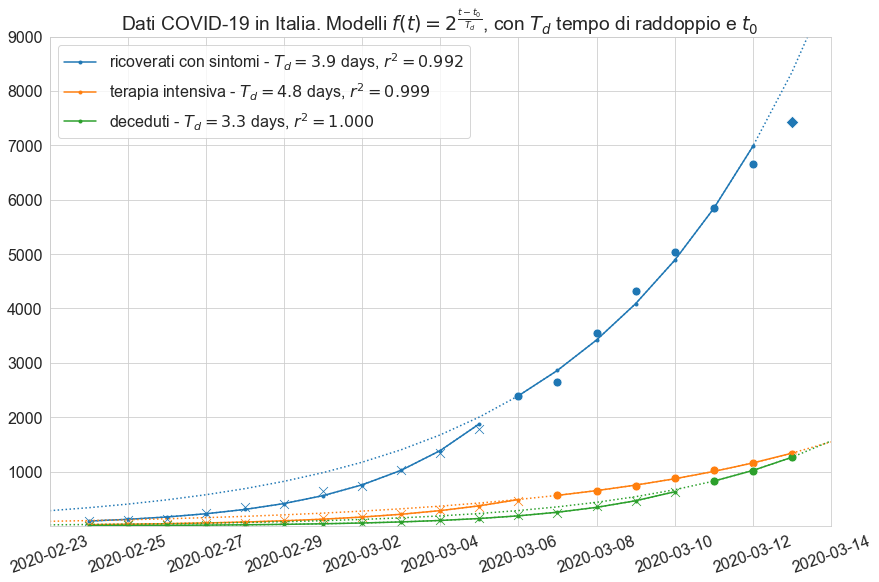

In [8]:
_, ax = plt.subplots(subplot_kw={'yscale': 'linear', 'ylim': (5, 9000)})
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_old'], color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_old'], color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_old'], color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind.replace('_', ' '), extrapolate=EXTRAPOLTATE, color=color, date_interval=2)

_ = ax.set(title=r'Dati COVID-19 in Italia. Modelli $f(t) = 2 ^ \frac{t - t_0}{T_d}$, con $T_d$ tempo di raddoppio e $t_0$ ')

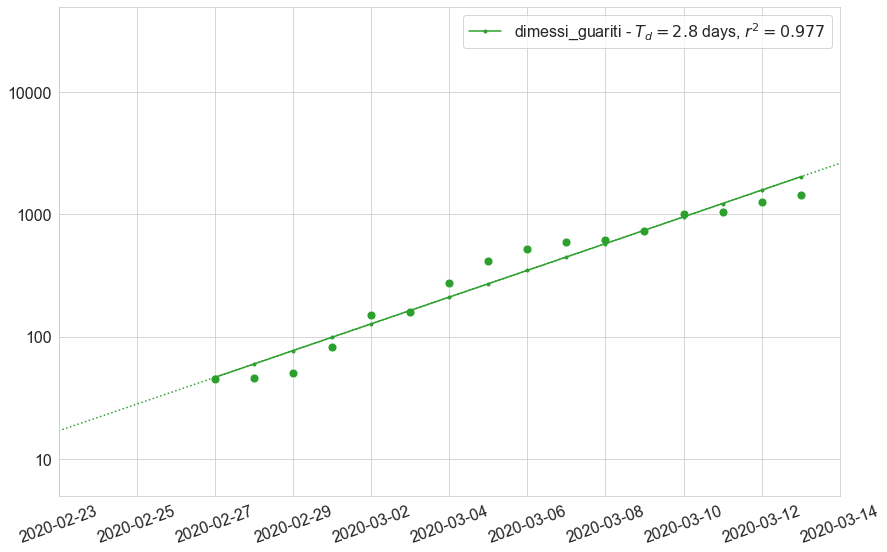

In [9]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 50000)})
kind = 'dimessi_guariti'
covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind, extrapolate=EXTRAPOLTATE, color=color)


## estimates

In [10]:
kinds = ['deceduti', 'terapia_intensiva', 'ricoverati_con_sintomi', 'dimessi_guariti']
datetime_expected = '2020-03-16'
expected_values = []
for kind in kinds:
    expected_values.append(int(round(fits[kind].predict(datetime_expected))))
print(', '.join(f'{k}: {v}' for v, k in zip(expected_values, kinds)))

deceduti: 2392, terapia_intensiva: 2063, ricoverati_con_sintomi: 14237, dimessi_guariti: 4316


In [11]:
for key, value in list(fits.items())[:10]:
    print(f'{key} {" " * (26 - len(key))}{str(value)}')

dimessi_guariti            T_d=2.75, t_0='2020-02-11', r^2=0.977 start='2020-02-27', stop='2020-03-13'
ricoverati_con_sintomi_old T_d=2.29, t_0='2020-02-09', r^2=0.993 start='2020-02-24', stop='2020-03-05'
terapia_intensiva_old      T_d=2.56, t_0='2020-02-12', r^2=0.996 start='2020-02-24', stop='2020-03-06'
deceduti_old               T_d=2.29, t_0='2020-02-17', r^2=0.999 start='2020-02-24', stop='2020-03-10'
ricoverati_con_sintomi     T_d=3.89, t_0='2020-01-22', r^2=0.992 start='2020-03-06', stop='2020-03-12'
terapia_intensiva          T_d=4.81, t_0='2020-01-23', r^2=0.999 start='2020-03-07', stop='2020-03-13'
deceduti                   T_d=3.26, t_0='2020-02-08', r^2=1.000 start='2020-03-11', stop='2020-03-13'
